In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import image_helper as ih
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

/Users/arseniybileckiy/PycharmProjects/Database3/venv/lib/python3.9/site-packages/seaborn/_statistics.py:31: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.1)
  from scipy.stats import gaussian_kde


In [ ]:
%load_ext autoreload
%autoreload 2

Считываем все данные из файлов. Получаем словарь {'Название файла': {цвет:процент,цвет:процент}}. Предполагается что файлы с флагами находятся в папке Flags

In [ ]:
fileDics = ih.GetFileDics()

In [10]:
fileDics['143px-Flag_of_Brazil.svg.png']

{21760: 0.6814685314685315,
 11184640: 0.17195804195804196,
 85: 0.11573426573426573}

Отбираем коды уникальных цветов (27), формируем матрицу признаков - Х. Заполняем по аналогии с OneHotEncoding. Если в экземпляре присутствует цвет - проставляем процент, который присутствует (в сотых долях - как считалось). Если цвет не присутствует - оставляем 0. Создаем и настраиваем алгоритм кластеризации

In [12]:
uniqueColors = set(x for dic in fileDics.values() for x in dic) # множество всех цветов без дубликатов
len(uniqueColors)

27

In [22]:
dicFull = {key:0 for key in sorted(uniqueColors)}
dicFull

{0: 0,
 85: 0,
 170: 0,
 21760: 0,
 21845: 0,
 21930: 0,
 22015: 0,
 43520: 0,
 43690: 0,
 5570560: 0,
 5592320: 0,
 5592405: 0,
 5592490: 0,
 5614165: 0,
 5614250: 0,
 5614335: 0,
 11141120: 0,
 11162880: 0,
 11162965: 0,
 11184640: 0,
 11184725: 0,
 11184810: 0,
 16711680: 0,
 16733440: 0,
 16755200: 0,
 16776960: 0,
 16777215: 0}

In [23]:
fileFullDics = {}

for item in fileDics.items():
    file, dic = item
    dicFullCopy = dicFull.copy()
    for key in dic:
        dicFullCopy[key] = dic[key]
    fileFullDics[file] = list(dicFullCopy.values())

listOfVectors = list(fileFullDics.values())
listOfVectors # матрица признаков

[[0,
  0.11573426573426573,
  0,
  0.6814685314685315,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.17195804195804196,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.33,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.3795726495726496,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.26153846153846155],
 [0.32,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.32,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.32,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0.2777777777777778,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.2777777777777778,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.39265432098765435],
 [0,
  0.33,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.33,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.32],
 [0,
  0,
  0,
  0,
  0,
  0.5289333333333334,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.39266666

In [245]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score


# оценка алгоритма 
def my_scorer_dbscan(estimator, X, y=None):
    estimator.fit(X)
    # Метка -1 для шумовых точек. Функция вычитает количество шумовых точек из оценки. 
    # Чем больше шумовых точек, тем ниже оценка.
    # Бонус за максимальный размер кластера  
    return -1 * np.count_nonzero(estimator.labels_ == -1) + 8 * max(estimator.labels_)


param_grid = [{ "eps": np.linspace(0.2, 0.5, 40),
        "min_samples": [2,3,4] }]


grid_search = GridSearchCV(DBSCAN() , param_grid, cv=3, scoring=my_scorer_dbscan)
grid_search.fit(listOfVectors);

In [246]:
print(grid_search.best_params_)

clustering =grid_search.best_estimator_.fit(listOfVectors)
clustering.labels_, max(clustering.labels_),np.sum(clustering.labels_==-1),np.sum(clustering.labels_!=-1)

{'eps': 0.24615384615384617, 'min_samples': 2}


(array([ 0,  1, -1,  2,  3,  4,  0,  2,  2, -1, -1,  0,  2,  4,  3,  5, -1,
         0,  3,  6,  3, -1,  5,  0,  7,  8,  9,  0,  4, -1, -1,  8,  3, -1,
        -1,  3,  2, 10,  5,  3,  2,  3, -1, 11,  2, -1, 12,  3,  2,  3,  6,
        -1, -1,  3,  2, -1, 13,  3,  2,  2, -1,  1, -1, -1, -1,  3, -1, 14,
        -1,  3, 12,  3,  3,  2,  3,  3,  0,  5,  0,  2,  3,  3, 15,  3,  2,
         3,  0,  3,  3,  0,  3, 10,  3,  0, -1, 13, -1, 16,  3,  5, 17,  8,
        -1,  3,  3, -1, -1,  3, -1,  2, -1,  7,  3,  3, -1,  3, 18,  3,  3,
         3,  7, -1,  2, 11,  3,  3, 19, -1,  2,  0, -1, -1, 20,  2, -1, -1,
        16, -1,  2,  3, -1, 18, 20, -1, -1,  2,  2,  0, -1, -1, -1,  2, 20,
         3, 11, -1, -1,  3,  3,  3, -1, -1, -1, -1,  4,  2, -1, -1, 14, -1,
         3, 15,  3,  3, 20, 19,  2, 15,  0,  3,  9, 12, -1, 14,  3,  3, -1,
         0, 17, -1,  3, -1,  3,  2, -1,  3,  2, -1,  3,  8,  3,  2,  2, -1,
         3,  3]),
 20,
 57,
 149)

Отображаем получившиеся группы. Для DBSCAN группы groupId начинаются от -1 (группа, в которую попали все неотобранные флаги - шумовые точки) до max+2. Для KMeans от 0 до max+1

/Users/arseniybileckiy/PycharmProjects/Database3/ML_4c/HW_7/image_helper.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axarr = plt.subplots(min(len(names),rows),max(2,width), facecolor='lightgray') #sharex=True, sharey=True,


ValueError: Number of rows must be a positive integer, not 0

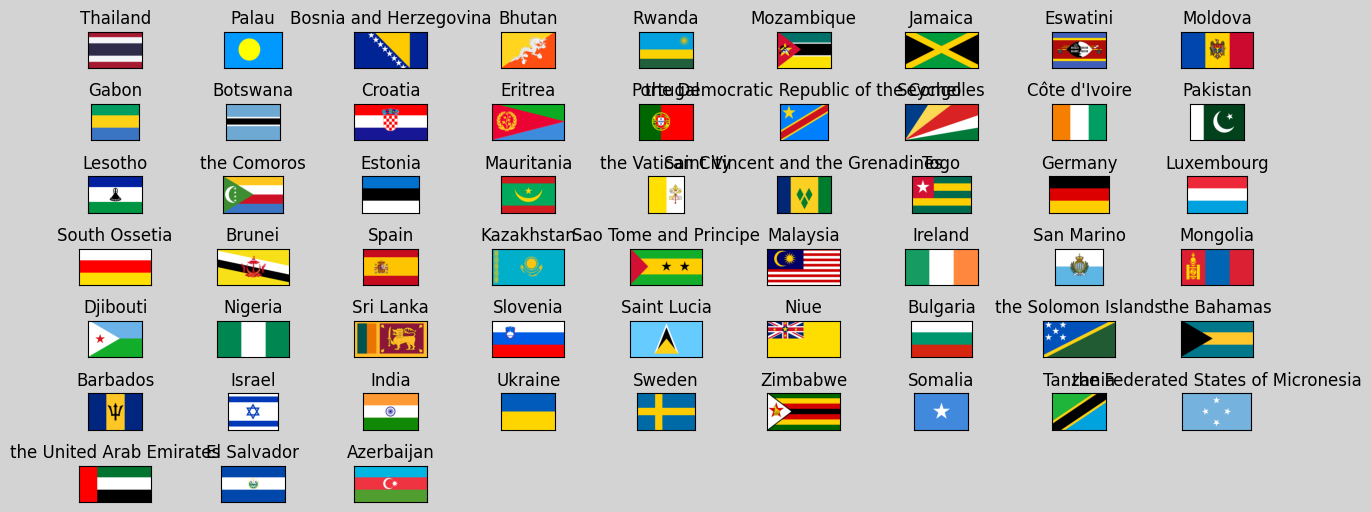

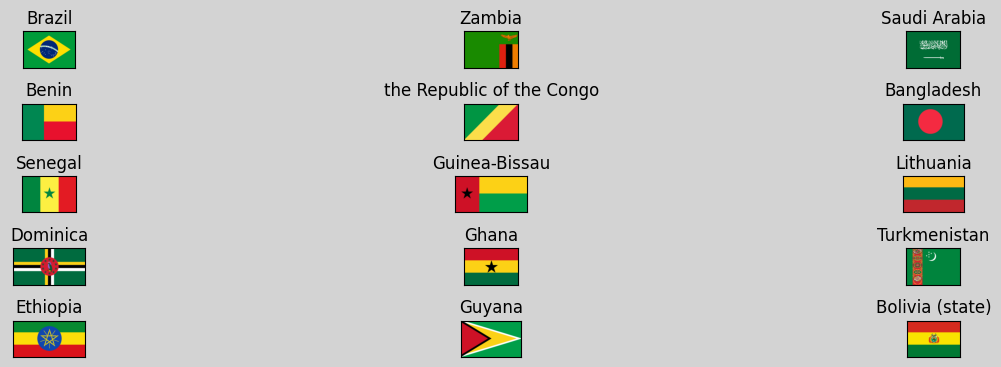

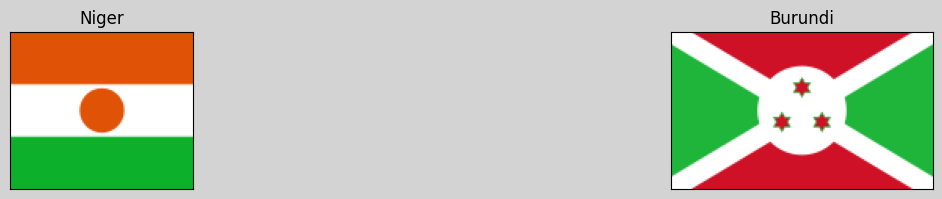

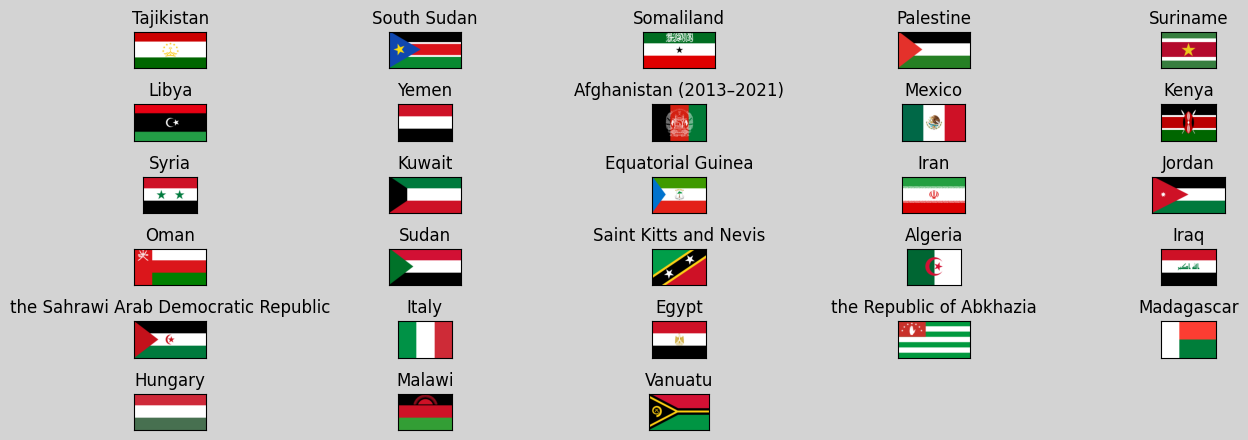

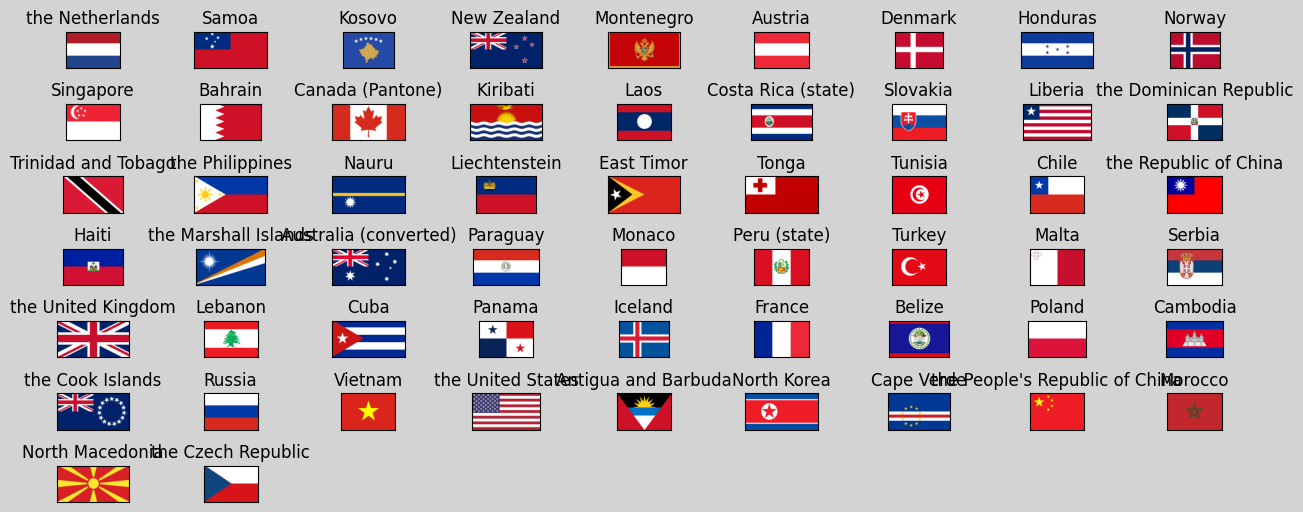

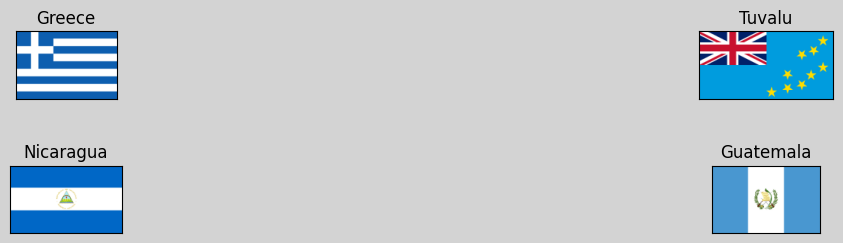

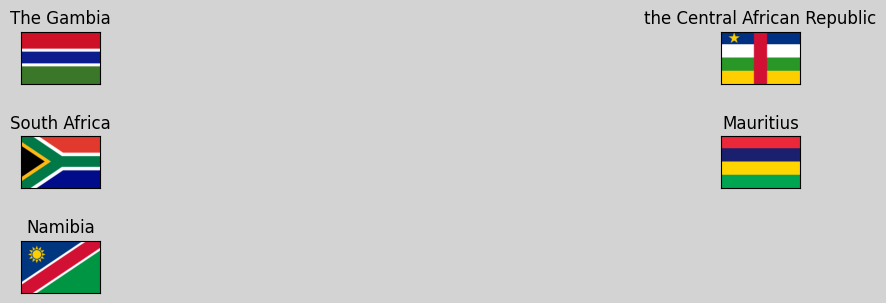

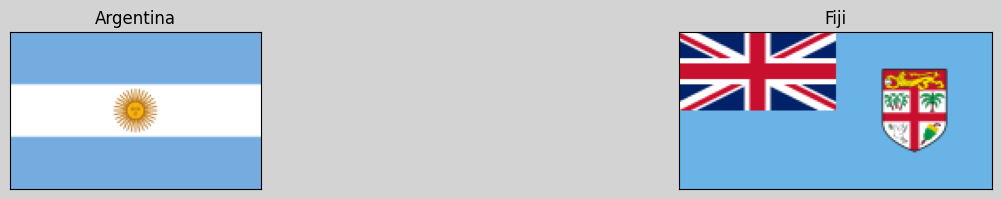

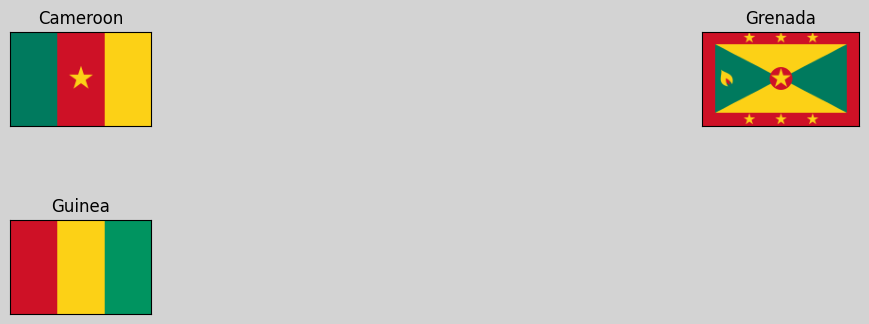

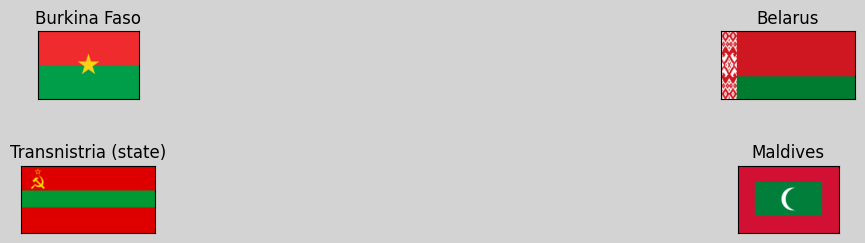

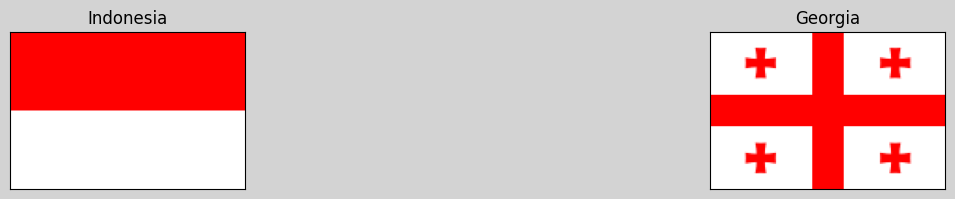

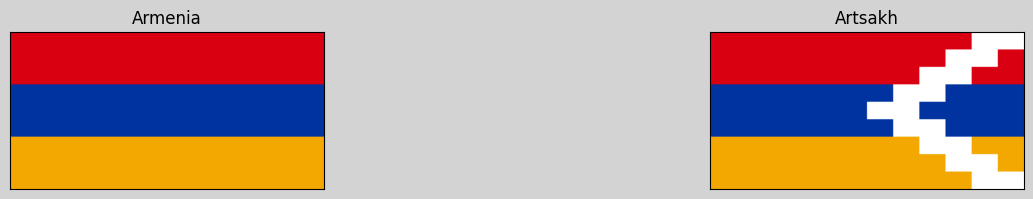

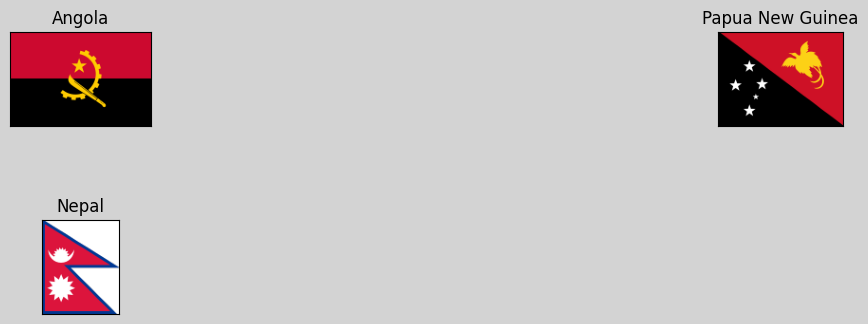

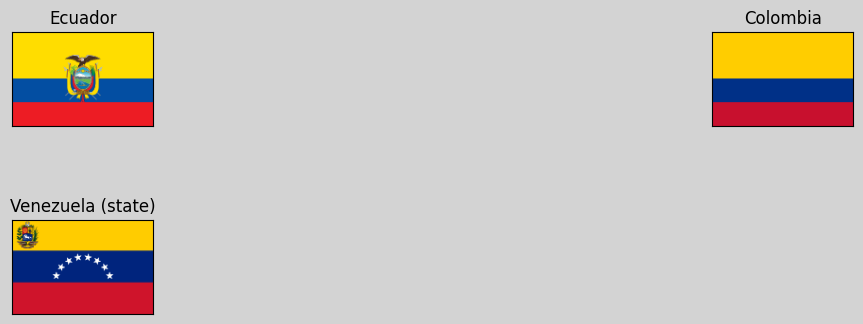

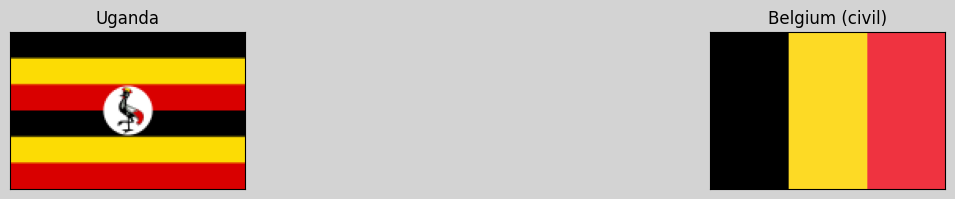

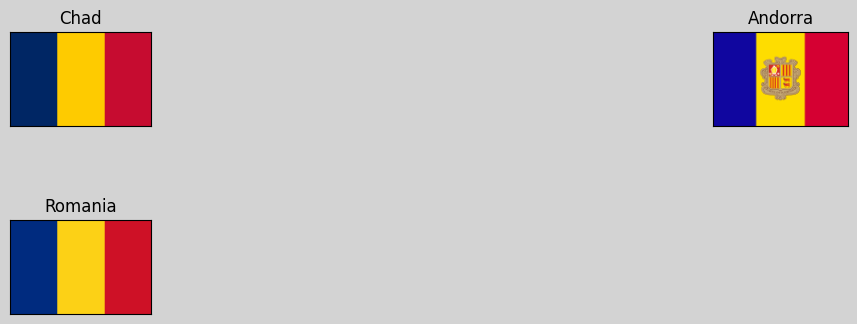

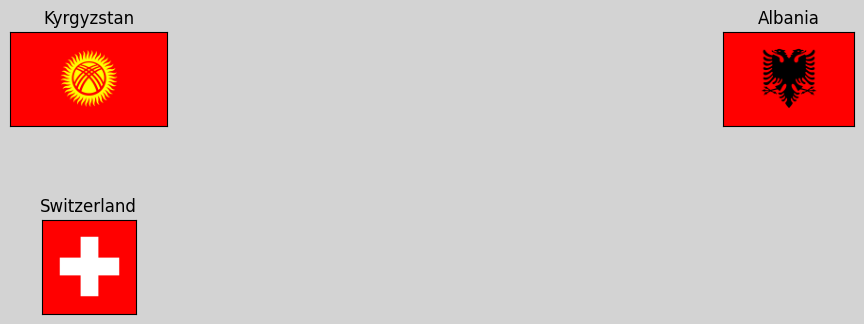

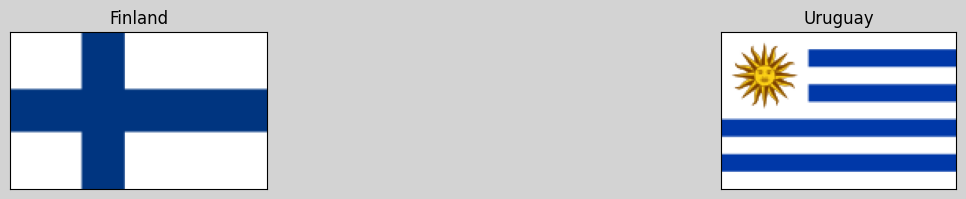

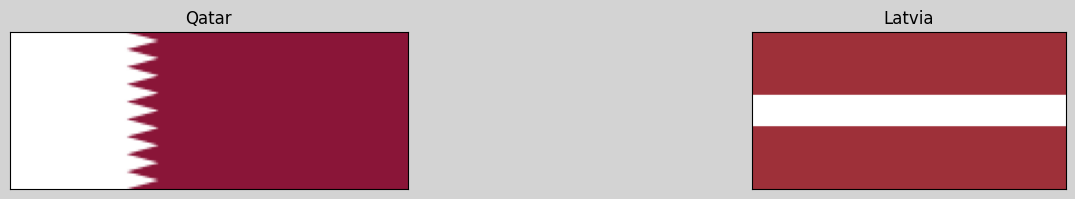

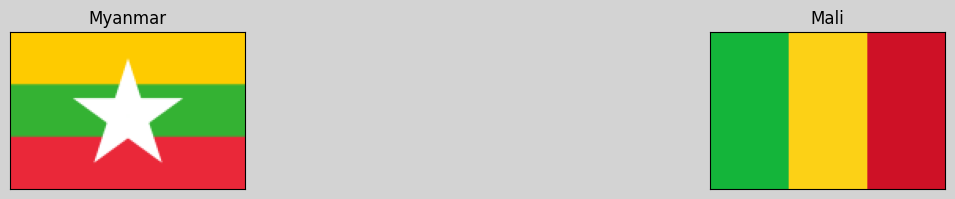

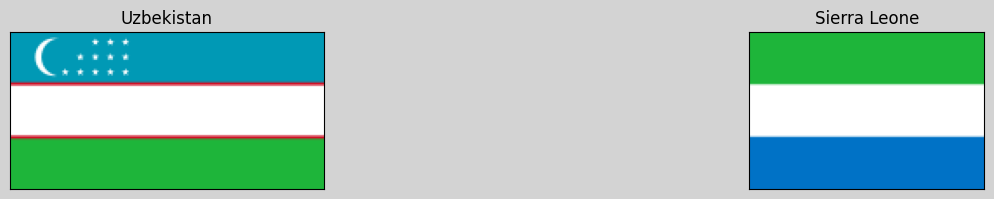

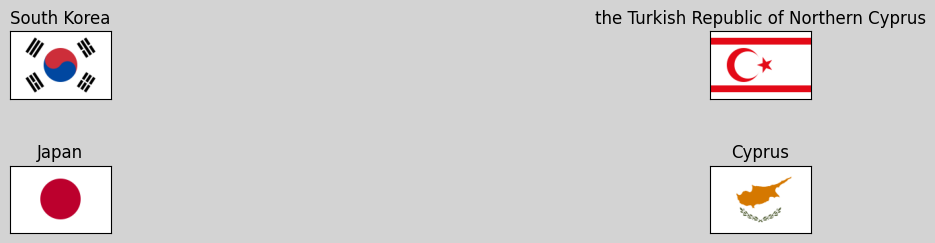

<Figure size 640x480 with 0 Axes>

In [247]:
for groupId in range(-1, max(clustering.labels_)+2):
    group = np.array(list(fileDics.keys()))[clustering.labels_ == groupId]
    ih.PrintGroup(group)

In [126]:
ncl = 50
inertia = [KMeans(n_clusters=i, init='k-means++').fit(listOfVectors).inertia_ for i in range(1,ncl)]


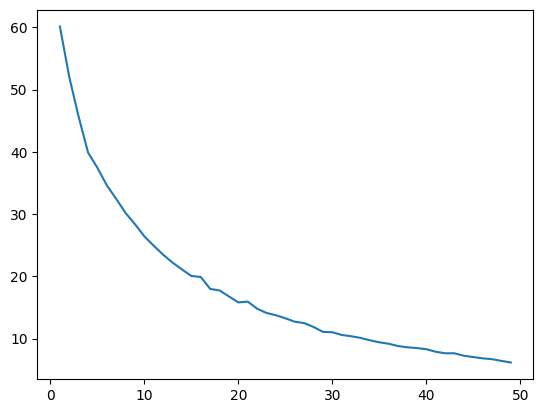

In [127]:
plt.plot(range(1,ncl), inertia)

In [248]:
kmeans = KMeans(n_clusters=20, init='k-means++').fit(listOfVectors)
kmeans.labels_

array([ 0, 10, 12,  4,  2,  7,  0, 12,  4, 18,  1,  0, 12,  7,  5,  4,  8,
        3,  1, 19,  1,  7,  4,  3,  9,  3,  8,  0,  7,  9, 12,  5,  5,  7,
        6, 17,  4,  2,  4,  5, 12,  1,  9, 12, 12, 12,  6,  5, 12, 17, 19,
        8, 10, 17,  4, 11, 14, 17, 12, 12, 18, 10,  4, 15, 12,  2,  4,  2,
        4,  2,  6,  2,  2,  4, 17,  2,  3,  6,  3,  4,  5,  2, 11,  1,  4,
        2,  3,  5,  5,  0,  5,  2, 17,  3,  7, 14,  9, 15,  5,  4, 16,  5,
        8,  2,  1,  3,  3,  1,  6, 12,  7,  9,  2, 17,  8, 17, 14,  5, 17,
        2,  9, 14,  4, 12,  2, 17, 10,  6, 12,  0, 13, 10, 15, 12, 15, 15,
       15, 19,  4,  2,  5, 14, 15, 10,  0, 12, 12,  3,  6,  8, 12,  4, 15,
       15, 12, 14, 17,  1,  2,  1,  3,  9,  1, 15,  7, 12,  4,  7,  2,  9,
       17, 11,  2,  1, 15, 10,  4, 11,  3,  2,  8,  6,  4,  2,  5, 17,  7,
        3, 16, 10, 12, 19,  2,  4, 12,  1,  4, 15,  5,  5,  5, 12, 12,  3,
        5,  2], dtype=int32)

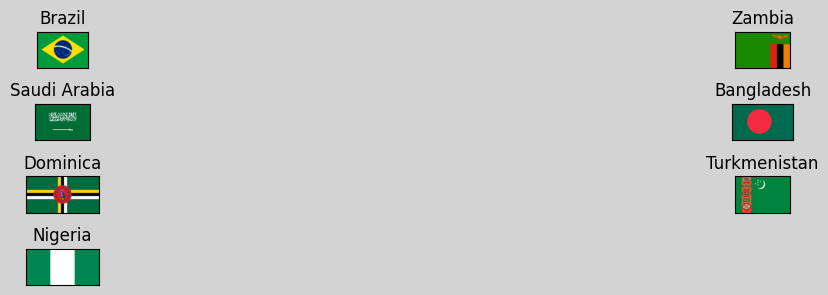

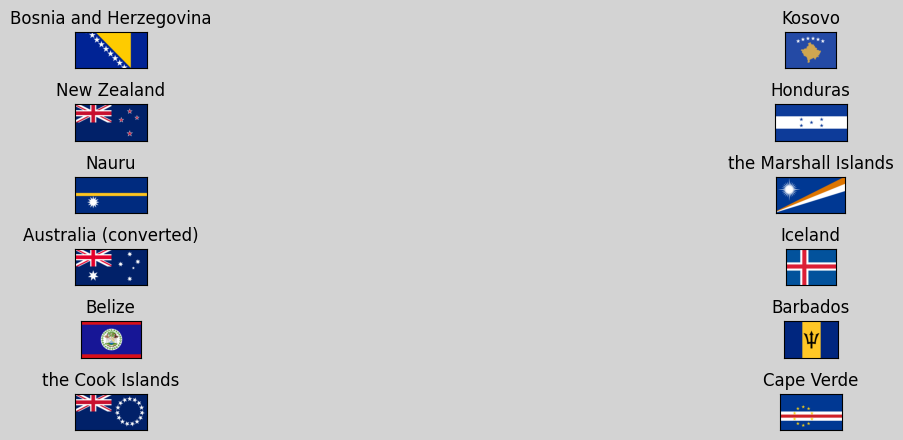

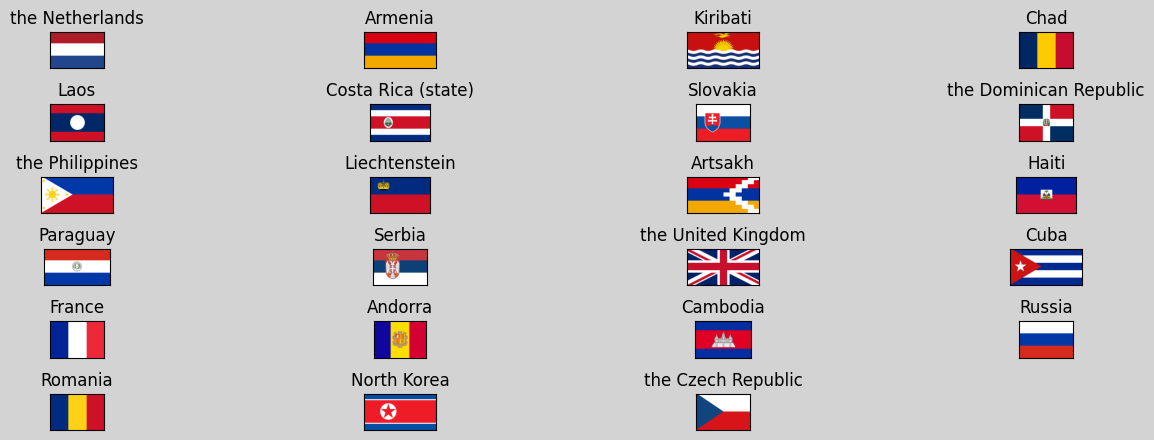

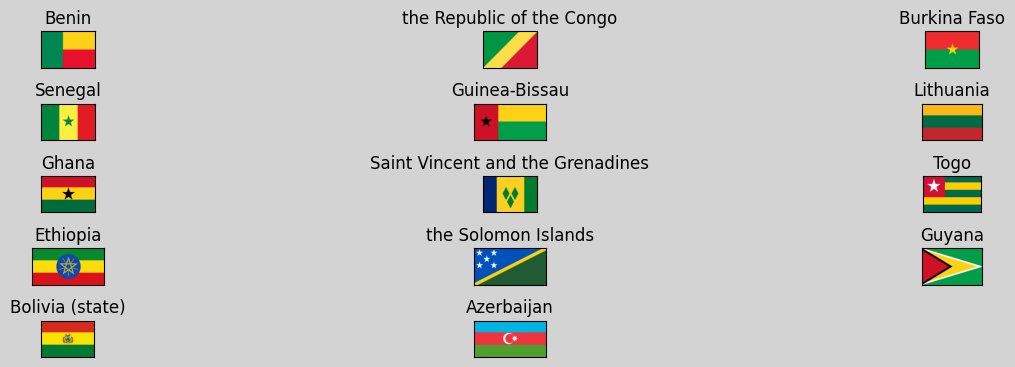

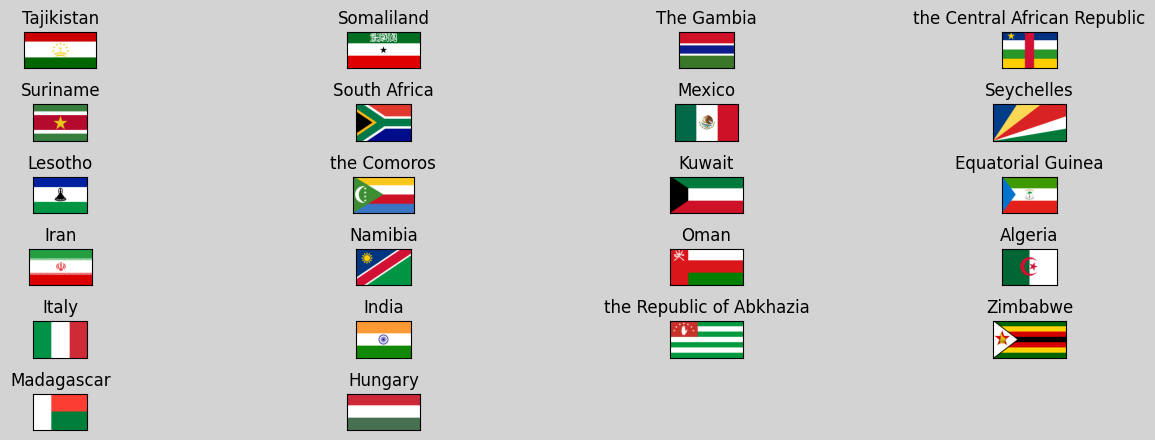

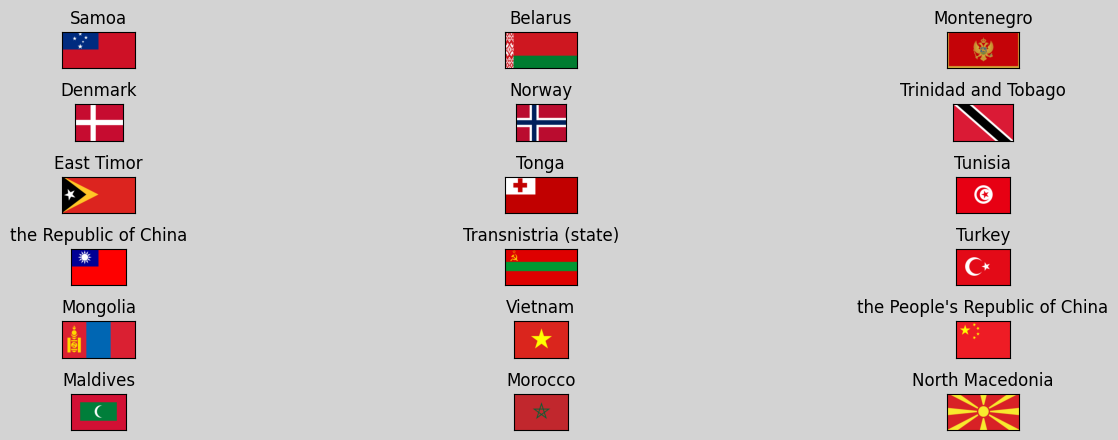

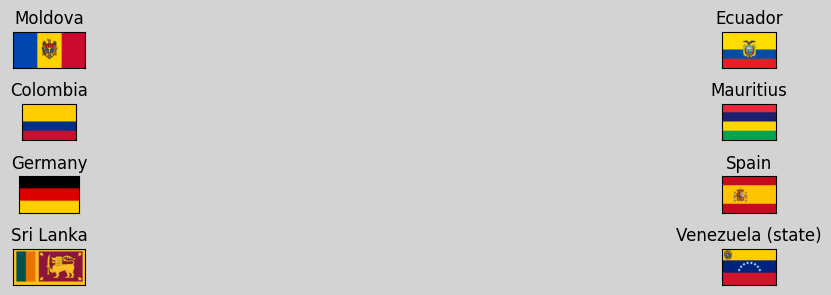

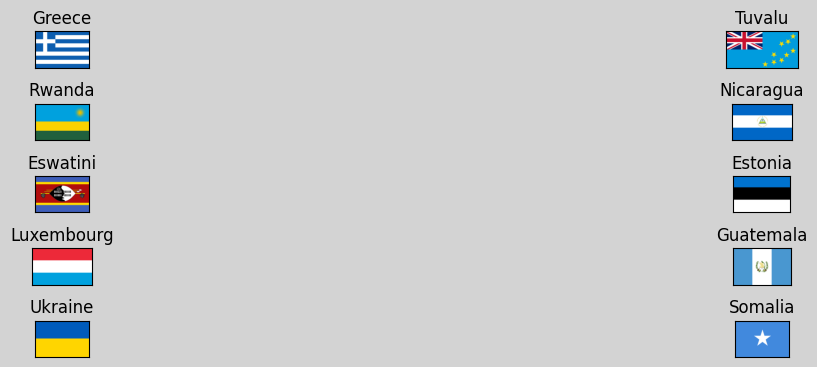

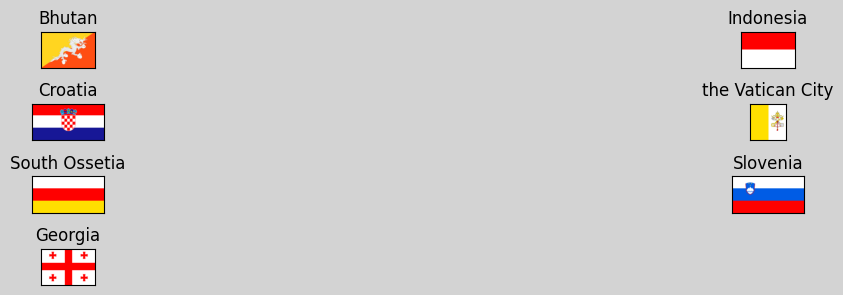

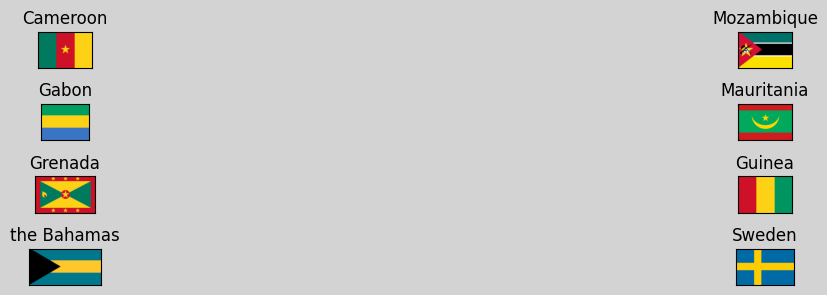

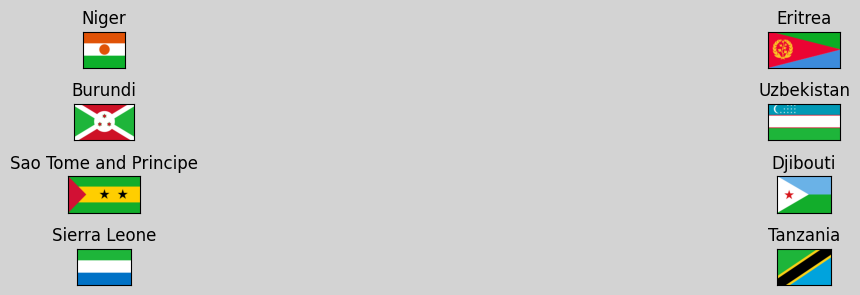

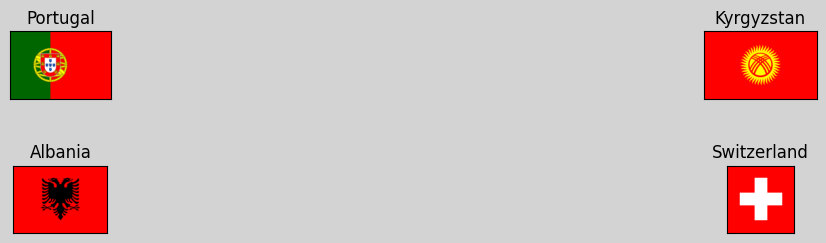

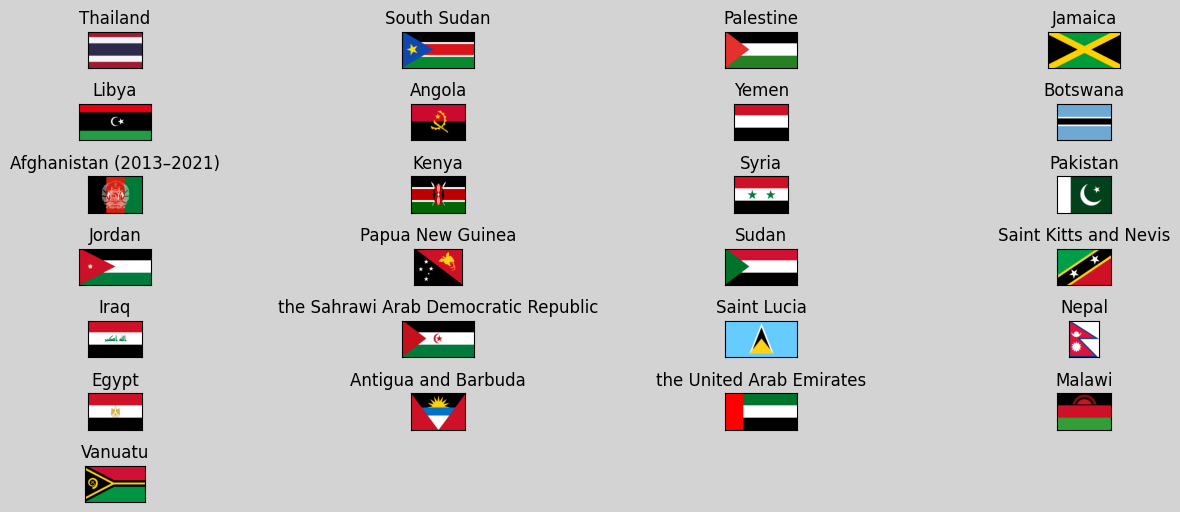

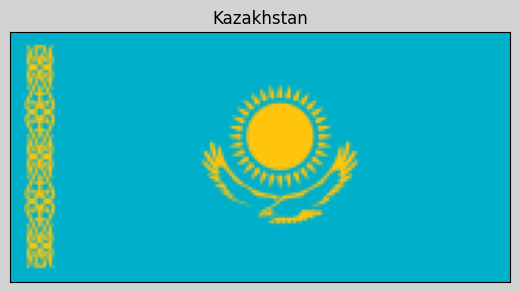

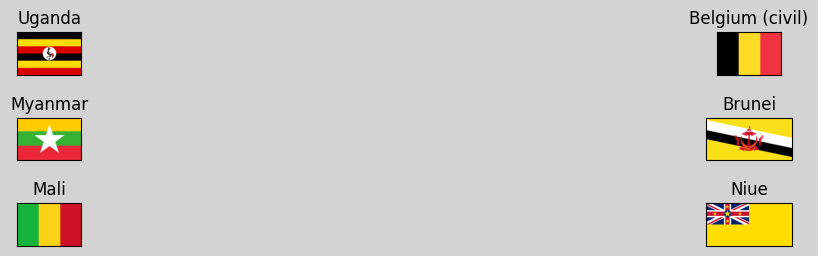

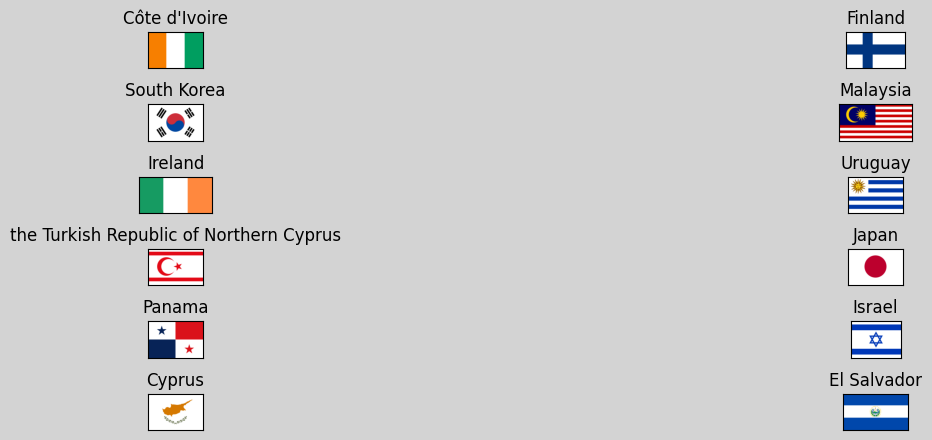

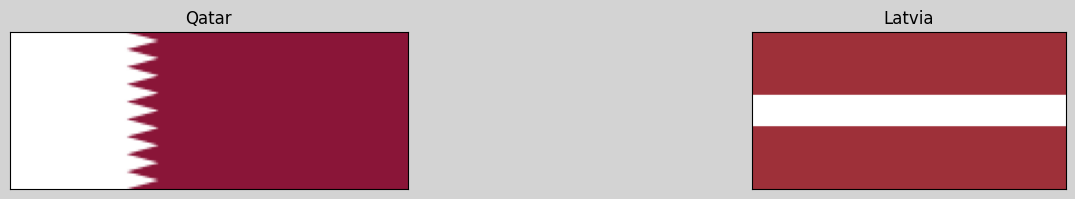

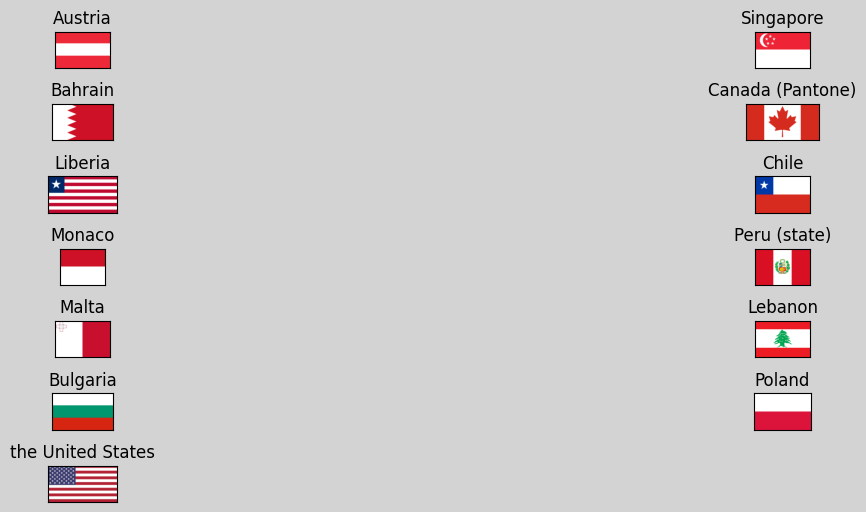

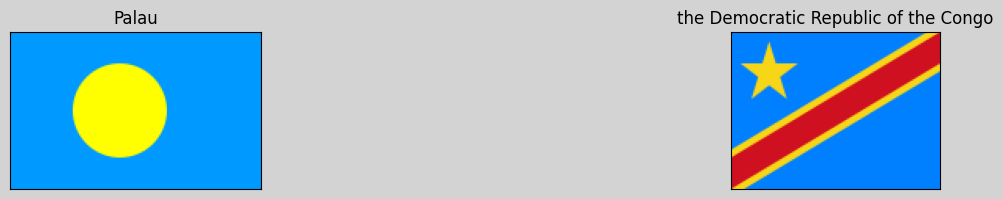

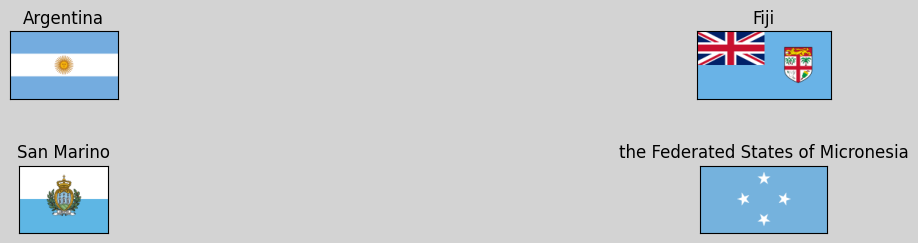

In [249]:
for groupId in range(max(kmeans.labels_)+1):
    group = np.array(list(fileFullDics.keys()))[kmeans.labels_ == groupId]
    ih.PrintGroup(group)

<b>Выводы:</b> своими словами как-то прокомментировать...

In [151]:
from sklearn.decomposition import PCA, KernelPCA

С помощью алгоритмов понижения размерности понизить размерность исходных признаков до двух. Результат сохранить в переменную X_pca

Отобразить полученный результат на плоскости

In [178]:
from sklearn.metrics import mean_squared_error
def my_scorer(estimator, X, y=None):
    X_reduced = estimator.transform(X)
    X_preimage = estimator.inverse_transform(X_reduced)
    return -1 * mean_squared_error(X, X_preimage)

In [232]:
from sklearn.model_selection import GridSearchCV
param_grid = [{ "degree": [1],
        "gamma": [3],
        "kernel": ["rbf"]  }]

kpca=KernelPCA(n_components=2, n_jobs=-1)
# kpca=KernelPCA(n_components=2, kernel="rbf", gamma=1, fit_inverse_transform=True, n_jobs=-1) 
grid_search = GridSearchCV(kpca, param_grid, cv=3, scoring=my_scorer)
grid_search.fit(listOfVectors)

/Users/arseniybileckiy/PycharmProjects/Database3/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/arseniybileckiy/PycharmProjects/Database3/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 759, in _score
    scores = scorer(estimator, X_test)
  File "/var/folders/mq/57wftyr93zx0870905kd68vc0000gn/T/ipykernel_6102/2256896799.py", line 4, in my_scorer
    X_preimage = estimator.inverse_transform(X_reduced)
  File "/Users/arseniybileckiy/PycharmProjects/Database3/venv/lib/python3.9/site-packages/sklearn/decomposition/_kernel_pca.py", line 546, in inverse_transform
    raise NotFittedError(
sklearn.exceptions.NotFittedError: The fit_inverse_transform parameter was not set to True when instantiating and hence the inverse transform is not available.

  warnings.warn(
/

GridSearchCV(cv=3, estimator=KernelPCA(n_components=2, n_jobs=-1),
             param_grid=[{'degree': [1], 'gamma': [3], 'kernel': ['rbf']}],
             scoring=<function my_scorer at 0x7fc068bcbd30>)

In [233]:
print(grid_search.best_params_)

{'degree': 1, 'gamma': 3, 'kernel': 'rbf'}


In [234]:
X_pca = grid_search.transform(listOfVectors)

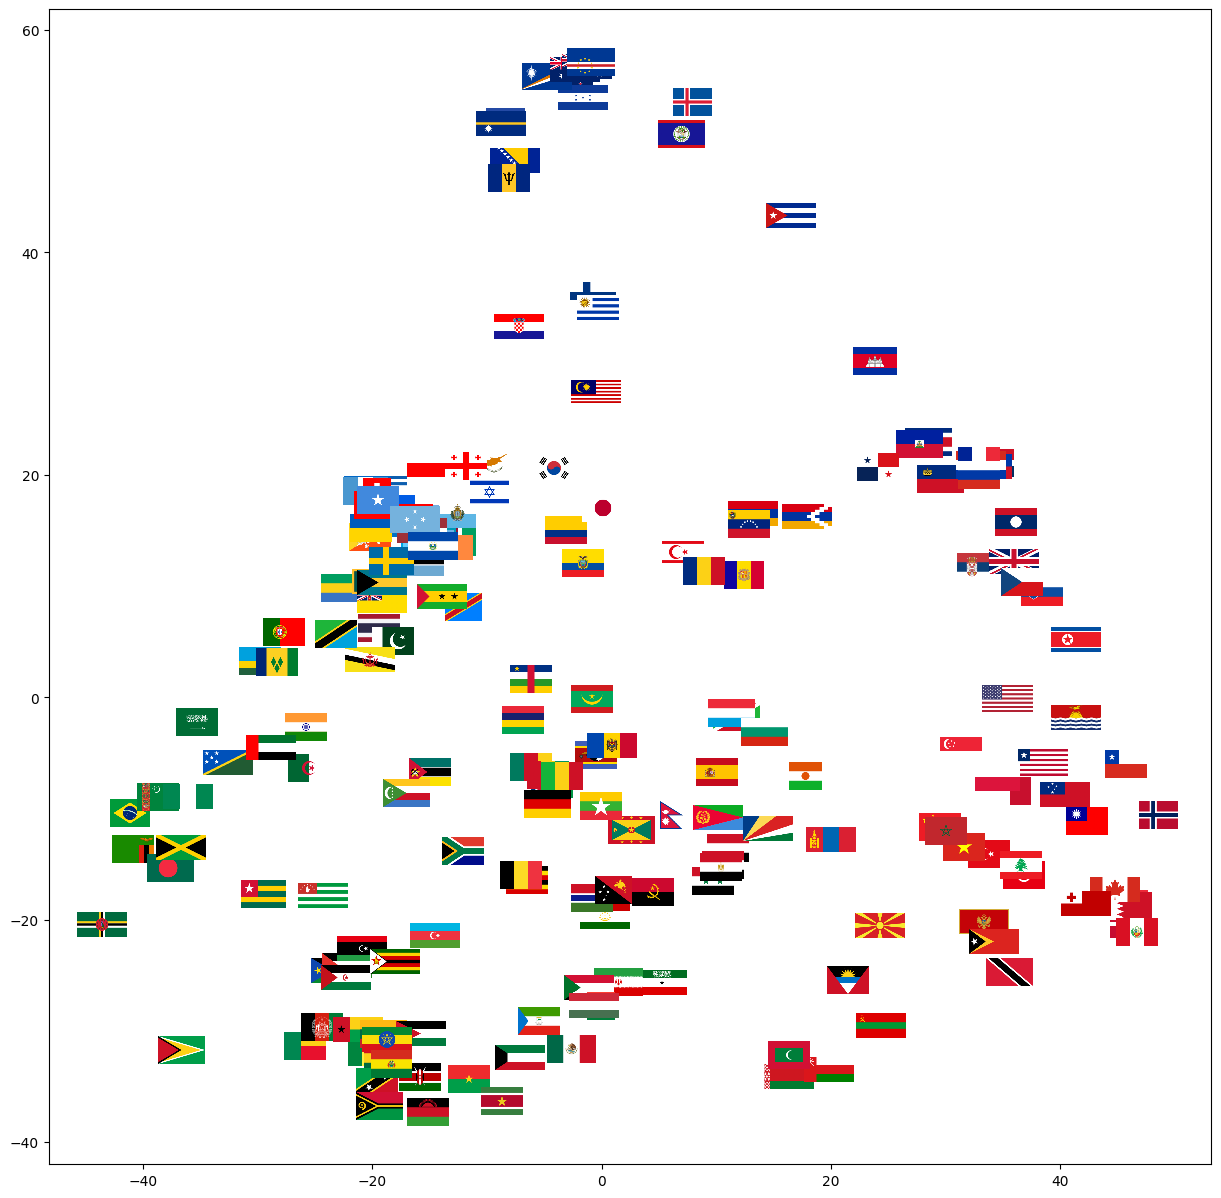

In [235]:
ih.PlotOnPlane(X_pca, fileDics.keys())